In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime, timedelta

# Mount Google Drive (if working on Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define file path in Google Drive
drive_path = "/content/drive/My Drive/TimeSeries/historical_data.csv"

# Load dataset
df = pd.read_csv(drive_path, parse_dates=['Date'], index_col='Date')

# Ensure the data is sorted by date
df = df.sort_index()

# Select the 'Close' column (assuming 'Close' is the column you want to predict)
data = df[['Close']].copy()



Mounted at /content/drive


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.0102 - val_loss: 0.0015
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 2.0657e-04 - val_loss: 0.0012
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.8206e-04 - val_loss: 9.1715e-04
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.9893e-04 - val_loss: 0.0014
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 1.9517e-04 - val_loss: 7.5742e-04
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1.6656e-04 - val_loss: 8.6556e-04
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 1.5112e-04 - val_loss: 6.0617e-04
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 1.6086e-04 - val_loss: 0.0019
Epoch 9/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.4113e-04 - val_loss: 6.6039e-04
Epoch 10/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.2501e-04 - val_loss: 4.5935e-04
Epoch 11/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1.1857e-04 - val_

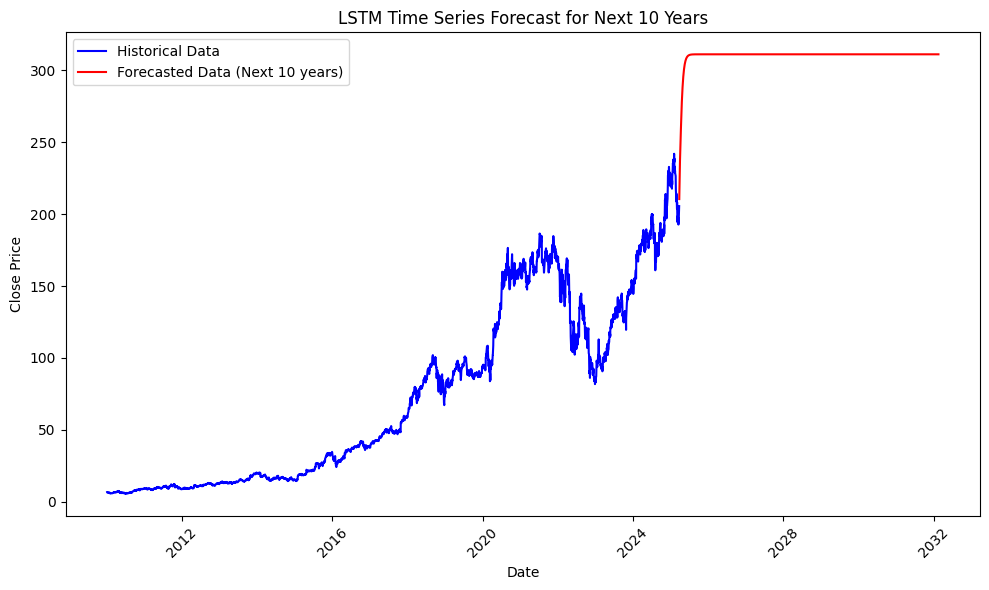

In [ ]:
# Normalize data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Prepare data for LSTM (function to create sequences of data)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 20  # Number of previous days to use for prediction
X, y = create_sequences(data_scaled, seq_length)

# Train-test split (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16)

# Predict future values (next 10 years)
forecast_steps = 10 * 252  # Assuming 252 trading days in a year
predictions = []

# Use the last seq_length data to start the prediction process
input_seq = data_scaled[-seq_length:].reshape(1, seq_length, 1)

for _ in range(forecast_steps):
    pred = model.predict(input_seq)
    predictions.append(pred[0, 0])
    input_seq = np.append(input_seq[:, 1:, :], pred.reshape(1, 1, 1), axis=1)

# Inverse scale the predictions to get the original values
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Generate future dates (next 10 years)
last_date = df.index[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, forecast_steps + 1)]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df.index, data, label='Historical Data', color='blue')
plt.plot(future_dates, predictions, label='Forecasted Data (Next 10 years)', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('LSTM Time Series Forecast for Next 10 Years')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
